# Twitter Sentiment Analysis

## Aryan Sharma


In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [126]:
df = pd.read_csv('Tweets.csv') # Read the file

### Exploratory Data Analysis (EDA)

In [127]:
df.head(5) # Visualize the dataset

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [128]:
df.info() # Look at column information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

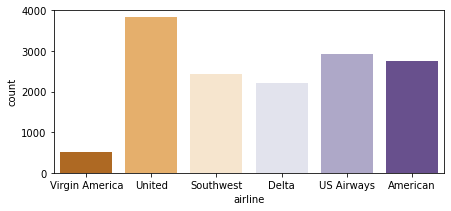

In [129]:
plt.figure(figsize=(7,3))
sns.countplot(x='airline', data=df, palette="PuOr")
plt.show() # Visualize count of tweets for each airline

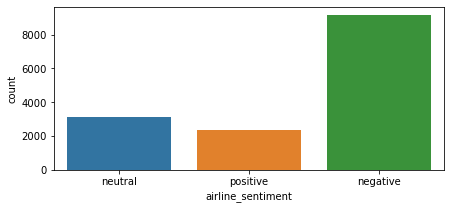

In [130]:
plt.figure(figsize=(7,3))
sns.countplot(x='airline_sentiment', data=df)
plt.show() # Visualize count of tweets of each sentiment

### Cleaning, Pre-processing Data and Tokenizing 

In [131]:
df2 = df['text'] #

df2 = df2.str.lower() # Converting to lowercase

def removing_sw(text): # Removing stopwords
    return " ".join([word for word in str(text).split() if word not in stopwords.words('English')])

df2 = df2.apply(lambda text: removing_sw(text))

def cleaner(t):
    t = re.sub(r'http\S+|www\S+|https\S+', '', t, flags=re.MULTILINE)  # remove urls
    t = re.sub(r'\@\w+|\#', '', t)  # remove at and hash tags
    t = t.encode('ascii', 'ignore').decode('ascii')  # remove emojis
    t = re.sub(r'\s+', ' ', t).strip()  # remove extra spaces
    t = re.sub('[0-9]+', '', t)
    t = re.sub(r'[^\w\s]', '', t)
    t = word_tokenize(t)
    #ps = PorterStemmer()
    #t = [ps.stem(w) for w in t]
    lemmatizer = WordNetLemmatizer()
    t = [lemmatizer.lemmatize(w, pos='a') for w in t]
    return t

df2 = df2.apply(lambda t: cleaner(t))
df2 = df2.to_list()
df3 = df2.copy()

### Vectorizing the Data

In [132]:
model = gensim.models.Word2Vec(sentences = df3, vector_size = 100, window = 5, min_count = 1, sg = 0)

In [133]:
# Vectorize text using the Word2Vec model
def vectorize_text(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Average the word vectors
    else:
        return np.zeros(model.vector_size)  # Use a zero vector for out-of-vocabulary words


In [134]:
# Vectorize the text data
vdf2 = [vectorize_text(text, model) for text in df2]

# Add the vectorized text to the DataFrame
df['word2vec_vectors'] = vdf2

# Encode the target labels
label_mapping = {"positive": 0, "negative": 1, "neutral": 2}
df['airline_sentiment_encoded'] = df['airline_sentiment'].map(label_mapping)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['word2vec_vectors'].to_list(), df['airline_sentiment_encoded'], test_size=0.2, random_state=42)

### Logistic Regression Model and Results

In [135]:
# Build and train a logistic regression model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_mapping.keys())

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7028688524590164
Classification Report:
               precision    recall  f1-score   support

    positive       0.75      0.33      0.46       459
    negative       0.71      0.97      0.82      1889
     neutral       0.54      0.14      0.23       580

    accuracy                           0.70      2928
   macro avg       0.67      0.48      0.50      2928
weighted avg       0.68      0.70      0.64      2928



### Random Forest Model and Results

In [136]:
from sklearn.ensemble import RandomForestClassifier

# Build and train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_mapping.keys())

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7189207650273224
Classification Report:
               precision    recall  f1-score   support

    positive       0.65      0.44      0.52       459
    negative       0.75      0.91      0.83      1889
     neutral       0.54      0.32      0.40       580

    accuracy                           0.72      2928
   macro avg       0.65      0.56      0.58      2928
weighted avg       0.70      0.72      0.69      2928



### XGBoost Model and Results

In [137]:
import xgboost as xgb

# Build and train a Gradient Boosting (XGBoost) classifier
classifier = xgb.XGBClassifier(objective="multi:softmax", random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_mapping.keys())

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7233606557377049
Classification Report:
               precision    recall  f1-score   support

    positive       0.65      0.50      0.56       459
    negative       0.77      0.89      0.83      1889
     neutral       0.53      0.35      0.42       580

    accuracy                           0.72      2928
   macro avg       0.65      0.58      0.60      2928
weighted avg       0.70      0.72      0.70      2928



### SVM Model and Results

In [138]:
from sklearn.svm import SVC

# Build and train a Gradient Boosting (XGBoost) classifier
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_mapping.keys())

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6851092896174863
Classification Report:
               precision    recall  f1-score   support

    positive       0.75      0.26      0.39       459
    negative       0.68      0.99      0.81      1889
     neutral       0.69      0.04      0.08       580

    accuracy                           0.69      2928
   macro avg       0.71      0.43      0.42      2928
weighted avg       0.69      0.69      0.60      2928



### Interpretations and Explanations / Conclusions

Data Preprocessing - In the preprocessing step, we tokenized it, removed special characters and lemmatized the words.

Word2Vec Model Training - We trained a Word2Vec model on the preprocessed text data and it returns a list of 100 numbers for each word as a vector.

Using the trained Word2Vec model, we vectorized the preprocessed text data. 

We considered four different classification models: Logistic Regression, Random Forest, Gradient Boosting (XGBoost) and SVM. 

Model Training and Evaluation - For each model, we calculated accuracy and generated a classification report that includes precision, recall, F1-score, and support for each class (positive, negative, neutral).

Conclusion - From the above models, we see that all models have their positives and negatives across different classification buckets but from the results above the macro average is the highest for SVM while the weighted average of XGBoost is the highest, making these two the choice of consideration for airline tweet classification.